In [2]:
!pip install --upgrade scikit-learn
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: n

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s, f
from sklearn.metrics import mean_squared_error
import zipfile  # Handling ZIP archives for data extraction

In [52]:
# ===================== 1. Load DATA  =====================

# Load data from uploaded ZIP
from google.colab import files
uploaded = files.upload()

Saving question-custom-takehome-project-m8li6z2dnc-data.zip to question-custom-takehome-project-m8li6z2dnc-data (2).zip


In [53]:
# Extract data from ZIP
with zipfile.ZipFile('question-custom-takehome-project-m8li6z2dnc-data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

# --- Load datasets ---
products = pd.read_csv('/content/extracted_data/data/product.csv').drop(columns='Unnamed: 0')
sales = pd.read_csv('/content/extracted_data/data/sales.csv').drop(columns='Unnamed: 0')
sales['date'] = pd.to_datetime(sales['date'])

In [54]:
# ===================== 2. DATA VALIDATION =====================
# 1. Check missing values
print("MISSING VALUES:")
print("Products:\n", products.isnull().sum())
print("\nSales:\n", sales.isnull().sum())

# 2. Basic groupby stats
print("\nPRODUCT SUMMARY (by brand):")
print(products.groupby('brand').size())

print("\nSALES SUMMARY (by product):")
print(sales.groupby('product_id')['units'].sum().nlargest(5))

MISSING VALUES:
Products:
 brand                   0
flavour                 0
volume_per_joghurt_g    0
packsize                0
product_id              0
dtype: int64

Sales:
 date          0
product_id    0
price         0
units         0
dtype: int64

PRODUCT SUMMARY (by brand):
brand
Actimel              1
Activia              2
Alnatura             3
Danone               5
Ecke-Mit-Was-Drin    2
Ja!                  2
Mueller              4
Oikos                4
Rewe                 4
dtype: int64

SALES SUMMARY (by product):
product_id
20    15638.0
13    15451.0
4     15026.0
8     14659.0
16    14580.0
Name: units, dtype: float64


=== DESCRIPTIVE STATISTICS ===
        price    units
count  260.00   260.00
mean     5.29  1177.50
std      1.88   401.77
min      1.46    16.00
25%      3.97   944.00
50%      5.14  1275.50
75%      6.78  1453.25
max      9.42  2170.00

Flavour-level summary:
             price          units      
              mean count     mean count
flavour                                
blueberry     5.66    66  1012.76    66
chocolate     4.82    50  1424.82    50
raspberry     6.91    29   769.59    29
straciatella  5.09    60  1380.43    60
strawberry    4.63    55  1144.04    55


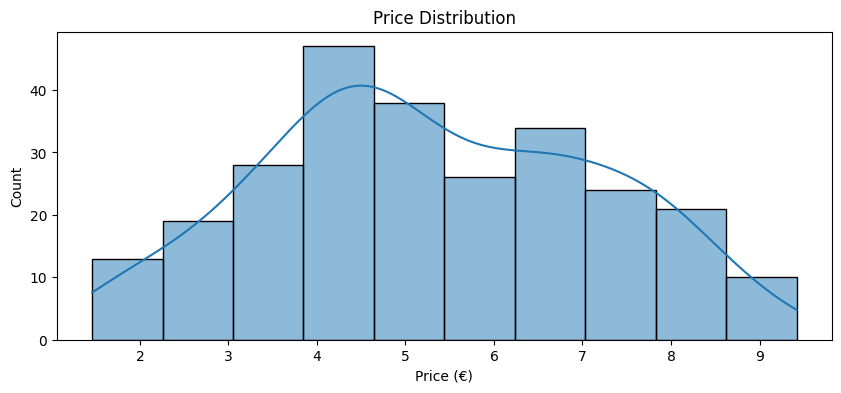

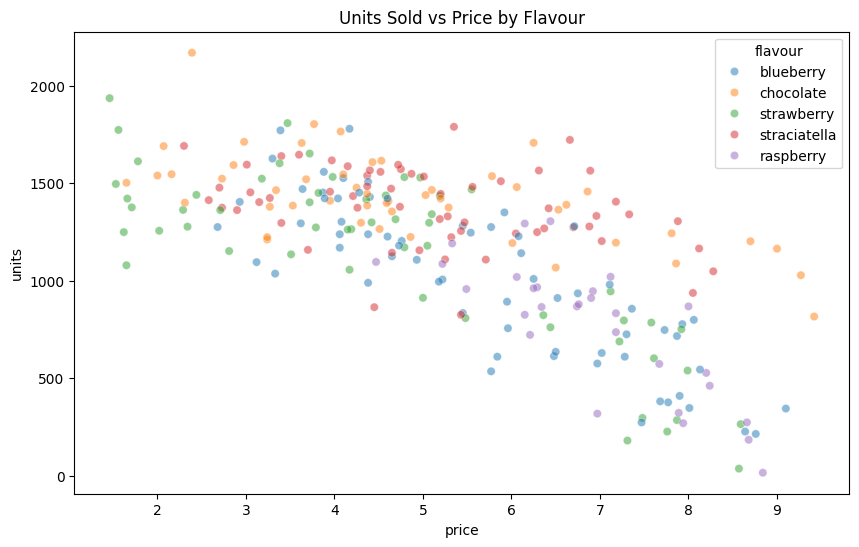

In [55]:
# ===================== 2. Exploratory Data Analysis =====================

# Merge datasets
merged = pd.merge(sales, products, on='product_id', how='left')

# Descriptive statistics
print("=== DESCRIPTIVE STATISTICS ===")
print(merged[['price', 'units']].describe().round(2))
print("\nFlavour-level summary:")
print(merged.groupby('flavour')[['price','units']].agg(['mean','count']).round(2))

# Plot: Price distribution
plt.figure(figsize=(10,4))
sns.histplot(merged['price'], kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (€)")
plt.show()

# Plot: Units vs Price (Elasticity trend)
plt.figure(figsize=(10,6))
sns.scatterplot(x='price', y='units', hue='flavour', data=merged, alpha=0.5)
plt.title("Units Sold vs Price by Flavour")
plt.show()

/tmp/ipython-input-56-2153043420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_sales.index, y=brand_sales.values, palette="viridis")


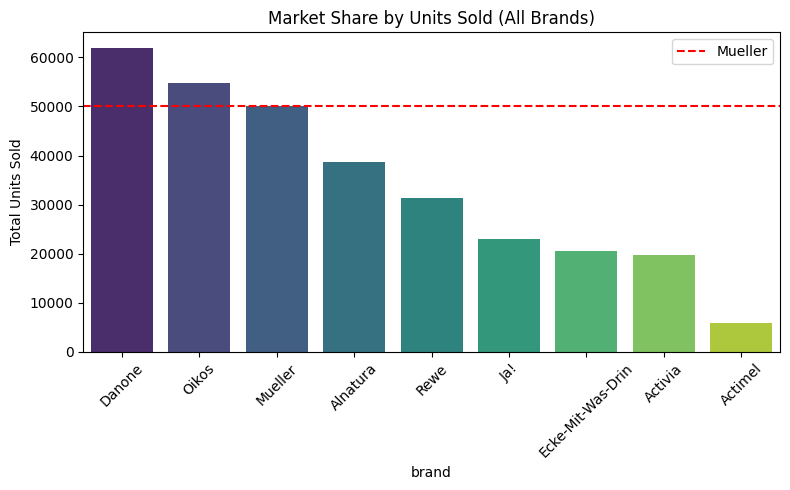

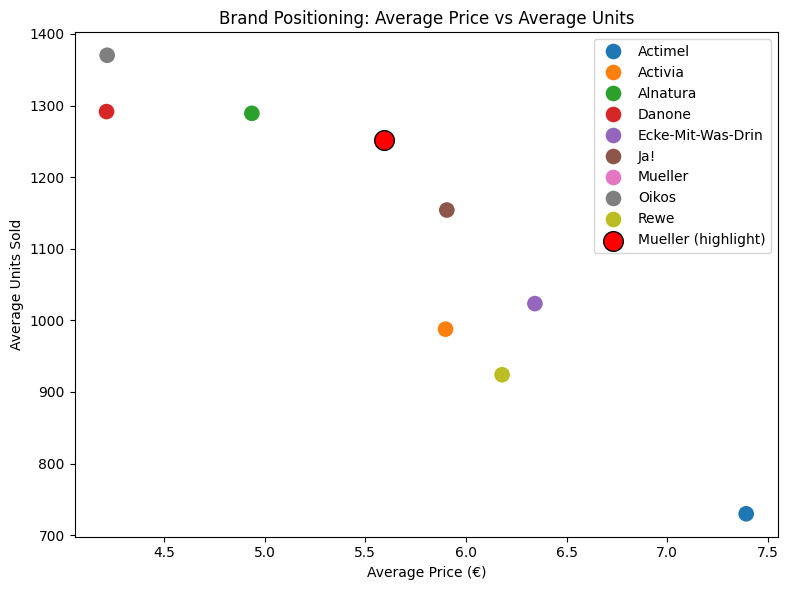

/tmp/ipython-input-56-2153043420.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flavour_units.index, y=flavour_units.values, palette="coolwarm")


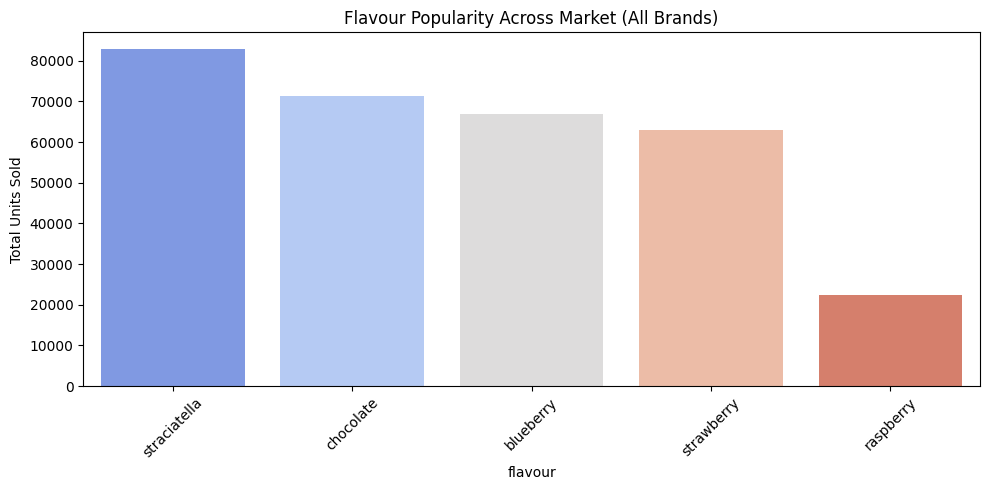

In [56]:
# ===================== 3. MARKET ANALYSIS =====================

# --- 1. Market share (units sold) ---
plt.figure(figsize=(8,5))
brand_sales = merged.groupby('brand')['units'].sum().sort_values(ascending=False)
sns.barplot(x=brand_sales.index, y=brand_sales.values, palette="viridis")

# Highlight Mueller
if 'Mueller' in brand_sales.index:
    mueller_value = brand_sales['Mueller']
    plt.axhline(mueller_value, color='red', linestyle='--', label='Mueller')

plt.title("Market Share by Units Sold (All Brands)")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. Price vs Units Positioning ---
brand_stats = merged.groupby('brand')[['price','units']].mean().reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(data=brand_stats, x='price', y='units', hue='brand', s=150)

# Highlight Mueller point
mueller_stats = brand_stats[brand_stats['brand']=='Mueller']
plt.scatter(mueller_stats['price'], mueller_stats['units'],
            color='red', s=200, label='Mueller (highlight)', edgecolor='black')

plt.title("Brand Positioning: Average Price vs Average Units")
plt.xlabel("Average Price (€)")
plt.ylabel("Average Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Flavour popularity across entire market ---
plt.figure(figsize=(10,5))
flavour_units = merged.groupby('flavour')['units'].sum().sort_values(ascending=False)
sns.barplot(x=flavour_units.index, y=flavour_units.values, palette="coolwarm")

plt.title("Flavour Popularity Across Market (All Brands)")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== Descriptive Stats (Mueller) ===
           price        units
count  40.000000    40.000000
mean    5.591250  1252.425000
std     1.645315   206.108869
min     2.700000   809.000000
25%     4.347500  1138.000000
50%     5.300000  1241.500000
75%     6.552500  1400.000000
max     9.420000  1780.000000


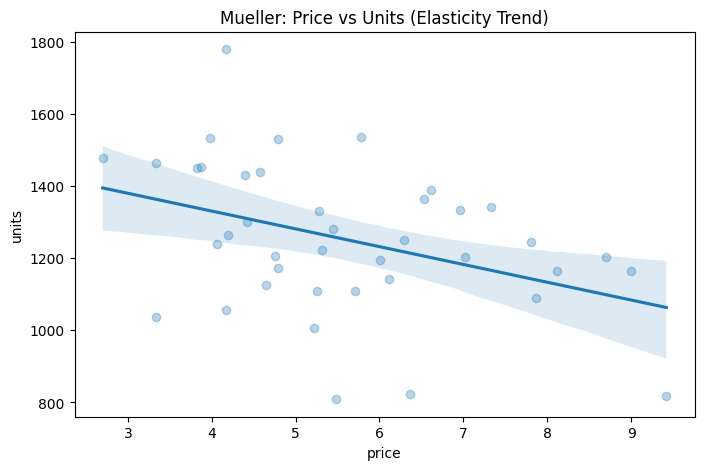

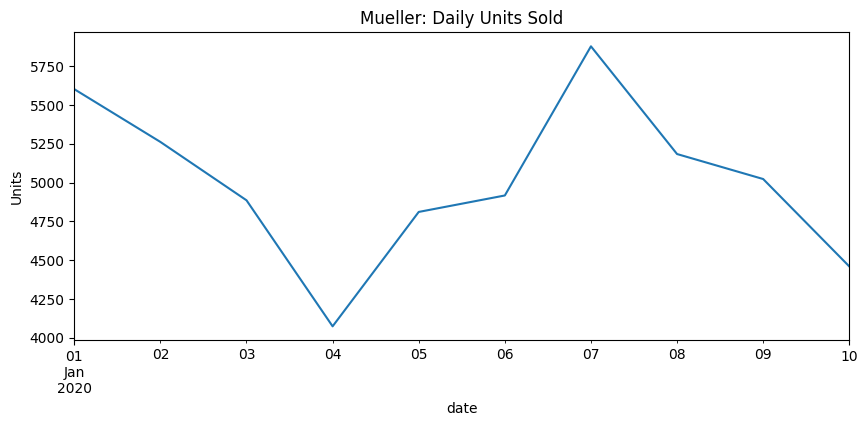

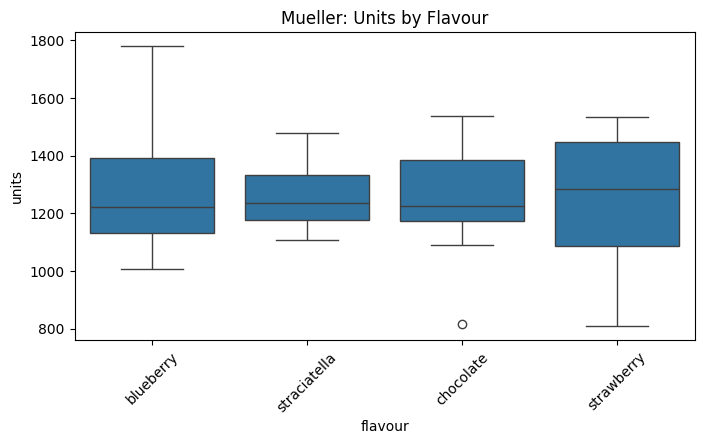

In [57]:
# ===================== 4. MARKET ANALYSIS With Focus on Mueller Brand =====================

# Exclude other brand
mueller_data = merged[merged['brand'] == 'Mueller'].copy()

# Encode flavour as numeric
mueller_data['flavour_code'] = pd.Categorical(mueller_data['flavour']).codes
flavour_map = dict(zip(mueller_data['flavour_code'], mueller_data['flavour']))

# EXPLORATORY ANALYSIS

print("\n=== Descriptive Stats (Mueller) ===")
print(mueller_data[['price','units']].describe())

# Plot price vs units (price elasticity trend)
plt.figure(figsize=(8,5))
sns.regplot(x='price', y='units', data=mueller_data, scatter_kws={'alpha':0.3})
plt.title("Mueller: Price vs Units (Elasticity Trend)")
plt.show()

# Plot daily sales trend
plt.figure(figsize=(10,4))
mueller_data.groupby('date')['units'].sum().plot()
plt.title("Mueller: Daily Units Sold")
plt.ylabel("Units")
plt.show()

# Flavour performance comparison
plt.figure(figsize=(8,4))
sns.boxplot(x='flavour', y='units', data=mueller_data)
plt.title("Mueller: Units by Flavour")
plt.xticks(rotation=45)
plt.show()



Feature Correlation Analysis:
                     price  price_market_avg     units
price             1.000000          0.286235 -0.704612
price_market_avg  0.286235          1.000000 -0.082117
units            -0.704612         -0.082117  1.000000


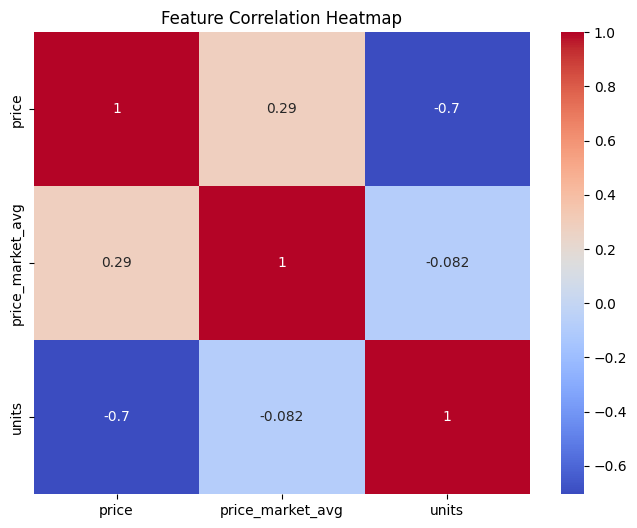

In [58]:
# ===================== 5. FEATURE ENGINEERING =====================

# Encode categorical variables
merged['flavour_code'] = pd.Categorical(merged['flavour']).codes
merged['brand_code'] = pd.Categorical(merged['brand']).codes

# Market-wide competitor price proxy (average price per day, excluding each product’s brand)
# This captures market dynamics rather than Mueller-specific competitor index
daily_avg_price = merged.groupby('date')['price'].mean()
merged = merged.join(daily_avg_price, on='date', rsuffix='_market_avg')

# Features: Price, Market Average Price, Flavour, Brand
X = merged[['price', 'price_market_avg', 'flavour_code', 'brand_code']]
y = merged['units']

print("\nFeature Correlation Analysis:")
print(merged[['price', 'price_market_avg', 'units']].corr())

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged[['price', 'price_market_avg', 'units']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [59]:
# ===================== 6. MARKET DEMAND MODEL (GAM) =====================

from pygam import LinearGAM, s, f

# GAM: smooth for price + market price, factors for flavour and brand
gam = LinearGAM(
    s(0) + s(1) + f(2) + f(3),
    fit_intercept=True
).fit(X, y)

# Evaluate vs baseline (mean units per product)
baseline_pred = merged.groupby('product_id')['units'].transform('mean')
print("\nModel Performance:")
print(f"Baseline RMSE: {np.sqrt(mean_squared_error(y, baseline_pred)):.1f}")
print(f"GAM RMSE: {np.sqrt(mean_squared_error(y, gam.predict(X))):.1f}")


Model Performance:
Baseline RMSE: 235.4
GAM RMSE: 205.5


In [60]:
# ===================== 7. OPTIMIZATION FOR MUELLER =====================

def optimize_mueller(flavour_name):
    """
    Optimize Mueller pricing using market-level model.
    Sets brand_code to Mueller but uses full market model for prediction.
    """
    # Map flavour and brand
    flavour_code = [k for k,v in dict(zip(merged['flavour_code'], merged['flavour'])).items() if v == flavour_name][0]
    mueller_code = merged[merged['brand'] == 'Mueller']['brand_code'].iloc[0]

    # Price range based on overall market
    price_range = np.linspace(merged['price'].quantile(0.1), merged['price'].quantile(0.9), 100)

    # Assume market average price stays constant at median
    market_avg_price = merged['price_market_avg'].median()

    # Predict units and revenue
    X_test = pd.DataFrame({
        'price': price_range,
        'price_market_avg': market_avg_price,
        'flavour_code': flavour_code,
        'brand_code': mueller_code
    })

    pred_units = gam.predict(X_test)
    revenue = price_range * pred_units
    optimal_idx = np.argmax(revenue)

    return {
        'flavour': flavour_name,
        'optimal_price': round(price_range[optimal_idx], 2),
        'max_revenue': round(revenue[optimal_idx], 2)
    }

# Generate optimization for all Mueller flavours
mueller_flavours = merged[merged['brand'] == 'Mueller']['flavour'].unique()
results = pd.DataFrame([optimize_mueller(f) for f in mueller_flavours])

print("\nOptimal Pricing Recommendations for Mueller:")
print(results.to_markdown(index=False))


Optimal Pricing Recommendations for Mueller:
| flavour      |   optimal_price |   max_revenue |
|:-------------|----------------:|--------------:|
| blueberry    |            6.62 |       7153.05 |
| straciatella |            6.67 |       8882.92 |
| chocolate    |            6.72 |       9028.62 |
| strawberry   |            6.62 |       7004.99 |


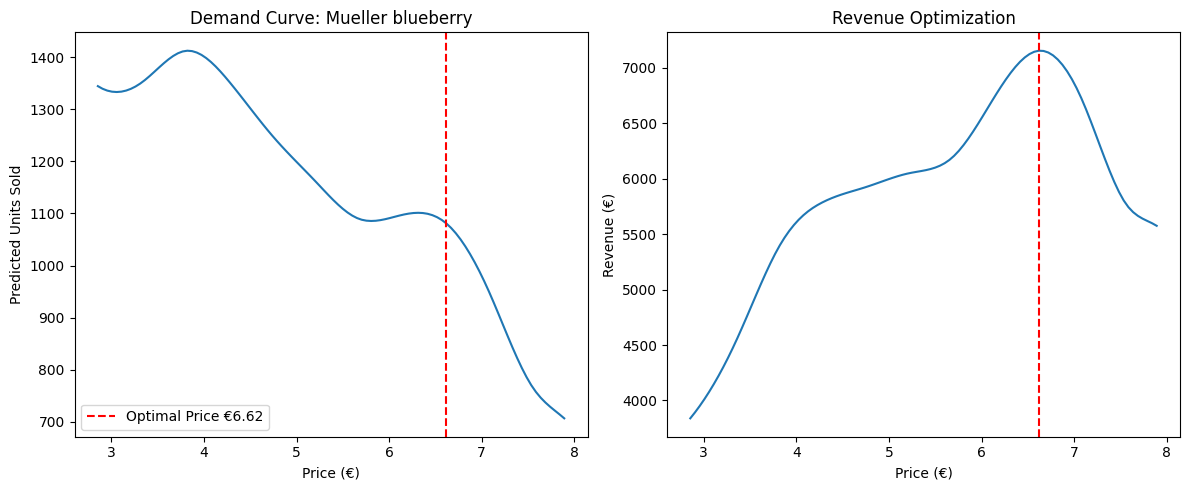

In [61]:
# ===================== 8. VISUALIZATION =====================

def plot_mueller_optimization(flavour_name):
    """Plot demand & revenue curves for Mueller flavour using market model."""
    res = optimize_mueller(flavour_name)
    flavour_code = [k for k,v in dict(zip(merged['flavour_code'], merged['flavour'])).items() if v == flavour_name][0]
    mueller_code = merged[merged['brand'] == 'Mueller']['brand_code'].iloc[0]

    price_range = np.linspace(merged['price'].quantile(0.1), merged['price'].quantile(0.9), 100)
    market_avg_price = merged['price_market_avg'].median()

    X_plot = pd.DataFrame({
        'price': price_range,
        'price_market_avg': market_avg_price,
        'flavour_code': flavour_code,
        'brand_code': mueller_code
    })

    pred_units = gam.predict(X_plot)
    revenue = price_range * pred_units
    opt_price = price_range[np.argmax(revenue)]

    # Plot demand curve
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(price_range, pred_units)
    plt.axvline(opt_price, color='red', linestyle='--', label=f'Optimal Price €{opt_price:.2f}')
    plt.xlabel("Price (€)")
    plt.ylabel("Predicted Units Sold")
    plt.title(f"Demand Curve: Mueller {flavour_name}")
    plt.legend()

    # Plot revenue curve
    plt.subplot(1,2,2)
    plt.plot(price_range, revenue)
    plt.axvline(opt_price, color='red', linestyle='--')
    plt.xlabel("Price (€)")
    plt.ylabel("Revenue (€)")
    plt.title("Revenue Optimization")
    plt.tight_layout()
    plt.show()

# Example: plot for first Mueller flavour
plot_mueller_optimization(mueller_flavours[0])

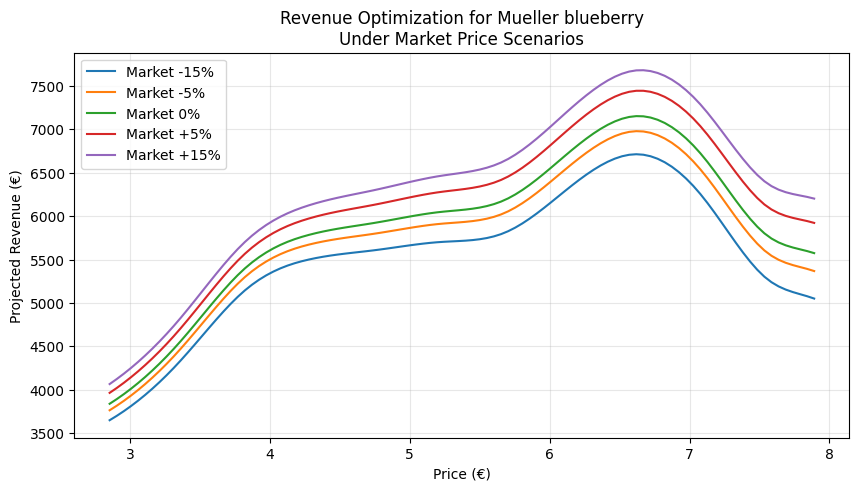


Scenario Summary (Market Shifts):
|   scenario |   optimal_price |   max_revenue |
|-----------:|----------------:|--------------:|
|      -0.15 |            6.62 |       6713.98 |
|      -0.05 |            6.62 |       6979.78 |
|       0    |            6.62 |       7153.05 |
|       0.05 |            6.67 |       7445.08 |
|       0.15 |            6.67 |       7681.86 |


In [62]:
# ===================== 9. BUSINESS SIMULATION =====================
def plot_sensitivity_analysis(flavour_name):
    """
    Visualize revenue optimization for Mueller flavour under different
    market average price scenarios (e.g., competitors price changes).
    """
    scenarios = [-0.15, -0.05, 0, 0.05, 0.15]  # Market price shifts (-15% to +15%)
    results = []

    plt.figure(figsize=(10,5))

    # Get flavour and Mueller brand codes
    flavour_code = [k for k, v in dict(zip(merged['flavour_code'], merged['flavour'])).items() if v == flavour_name][0]
    mueller_code = merged[merged['brand'] == 'Mueller']['brand_code'].iloc[0]

    # Price range for simulation (market-wide quantiles)
    price_range = np.linspace(
        merged['price'].quantile(0.1),
        merged['price'].quantile(0.9),
        100
    )

    # Loop through scenarios
    for scenario in scenarios:
        adjusted_market_price = merged['price_market_avg'].median() * (1 + scenario)

        # Prepare input features
        X_plot = pd.DataFrame({
            'price': price_range,
            'price_market_avg': adjusted_market_price,
            'flavour_code': flavour_code,
            'brand_code': mueller_code
        })

        # Predict revenue
        pred_units = gam.predict(X_plot)
        revenue = price_range * pred_units

        # Save result for summary
        results.append({
            'scenario': scenario,
            'optimal_price': price_range[np.argmax(revenue)],
            'max_revenue': revenue.max()
        })

        # Plot revenue curve for scenario
        label = f"Market {'+' if scenario > 0 else ''}{scenario*100:.0f}%"
        plt.plot(price_range, revenue, label=label)

    # Final plot adjustments
    plt.title(f"Revenue Optimization for Mueller {flavour_name}\nUnder Market Price Scenarios")
    plt.xlabel("Price (€)")
    plt.ylabel("Projected Revenue (€)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Print summary table
    results_df = pd.DataFrame(results)
    print("\nScenario Summary (Market Shifts):")
    print(results_df.round(2).to_markdown(index=False))


# Example: run for first Mueller flavour
plot_sensitivity_analysis(mueller_flavours[0])
